# Toy example

In [2]:
from CRSA import CRSA
from RSA import multi_classic_RSA
from random_model import random_model
from greedy_model import greedy_model
import torch
import random
import logging
import datetime

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model of the game
meanings_A = ["BAA", "ABA", "ABB", "BAB", "BBA"]
meanings_B = ["112", "221", "212", "122"]
utterances_A = ["1st position", "2nd position", "3rd position"]
utterances_B = ["1st position", "2nd position", "3rd position"]
Y = ["There is no (A,1) pair", "1st position", "2nd position", "3rd position"] # the question we try to answer is what is the position of the A,1 pair.

'''
# Define the prior
prior = torch.tensor([
    [[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0]],
    [[0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0]],
    [[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0]],
    [[0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0]],
    [[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]],
    ], device=device, dtype=torch.float32)

initial_prior = prior * 1/len(meanings_A) * 1/len(meanings_B)

# Define the lexica
lexicon_A = torch.tensor([
    [0, 1, 1], 
    [1, 0, 1], 
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    ], device=device, dtype=torch.float32)

lexicon_B = torch.tensor([
    [1, 1, 0], 
    [0, 0, 1], 
    [0, 1, 0],
    [1, 0, 0],
    ], device=device, dtype=torch.float32)
'''

full_meanings_A = ['BAA', 'ABA', 'ABB', 'BAB', 'BBA', 'AAA', 'AAB', 'BBB']
full_meanings_B = ['112', '221', '212', '122', '111', '121', '211', '222']

game_model = {"mA": full_meanings_A, "mB": full_meanings_B, "u": utterances_A, "v": utterances_B, "y": Y}

prior = torch.zeros((len(full_meanings_A), len(full_meanings_B), len(Y)), device=device, dtype=torch.float)

for i, mA in enumerate(full_meanings_A):
    for j, mB in enumerate(full_meanings_B):
        for k, y in enumerate(Y):
            intersect = set(id for id, char in enumerate(mA) if char == 'A').intersection(set(id for id, num in enumerate(mB) if num == '1'))
            if not intersect:
                prior[i,j,0] = 1
            else:
                for id in intersect:
                    prior[i,j,id+1] = 1
            prior[i,j] = prior[i,j] / prior[i,j].sum()

initial_prior = prior * 1/len(full_meanings_A) * 1/len(full_meanings_B)

lexicon_A = torch.zeros((len(full_meanings_A), len(utterances_A)), device=device, dtype=torch.float)
for i, mA in enumerate(full_meanings_A):
    for j, uA in enumerate(utterances_A):
        if j in set(id for id, char in enumerate(mA) if char == 'A'):
            lexicon_A[i,j] = 1

lexicon_B = torch.zeros((len(full_meanings_B), len(utterances_B)), device=device, dtype=torch.float)
for i, mB in enumerate(full_meanings_B):
    for j, uB in enumerate(utterances_B):
        if j in set(id for id, num in enumerate(mB) if num == '1'):
            lexicon_B[i,j] = 1

initial_lexica = [lexicon_A, lexicon_B]

# Fix the meanings observed by the agents
A_meaning = random.randint(0, len(meanings_A)-1)
B_meaning = random.randint(0, len(meanings_B)-1)

A_meaning = 1
B_meaning = 3

# Fix the utterances observed by the agents
# A_utterances = [1, 1, 1, 1]
A_utterances = None
B_utterances = None

# Define the parameters
alpha = 10
number_of_rounds = 3
RSA_depth = 2
verbose = True
sampling = "classic"

# Define the logging
date_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logging.basicConfig(filename='logs/output_'+date_string+'.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Run the Interactive RSA
estimations, produced_utterances, speakers, listeners = CRSA(
    initial_lexica = initial_lexica, 
    initial_prior = initial_prior, 
    game_model = game_model, 
    A_meaning = A_meaning, 
    B_meaning = B_meaning, 
    A_utterances = A_utterances, 
    B_utterances = B_utterances, 
    alpha = alpha,
    number_of_rounds = number_of_rounds,
    RSA_depth = RSA_depth,
    sampling = sampling, 
    device = device, 
    logging = logging, 
    verbose = verbose,
    )

Using device: cuda
Agent A observes: ABA / id=1.
Agent B observes: 122 / id=3.
Round: 0
Utterance of Agent A: 3rd position
Estimated truth by a Agent B: There is no (A,1) pair
Utterance of Agent B: 1st position
Estimated truth by a pragmatic Agent A: 1st position
Round: 1
Utterance of Agent A: 1st position
Estimated truth by a Agent B: 1st position
Utterance of Agent B: 1st position
Estimated truth by a pragmatic Agent A: 1st position
Round: 2
Utterance of Agent A: 3rd position
Estimated truth by a Agent B: 1st position
Utterance of Agent B: 1st position
Estimated truth by a pragmatic Agent A: 3rd position


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


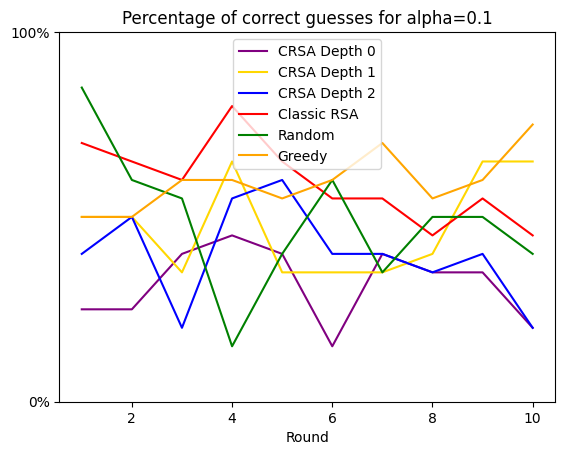

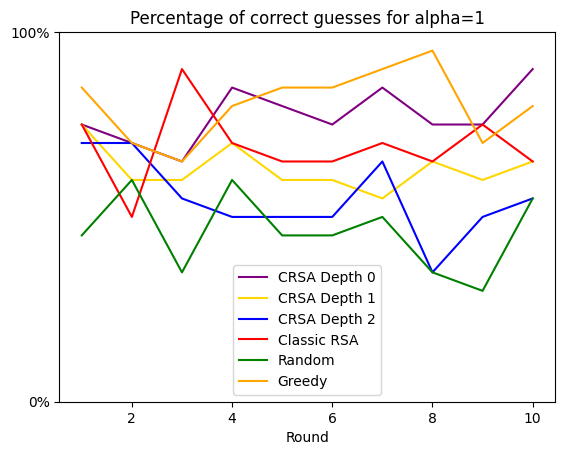

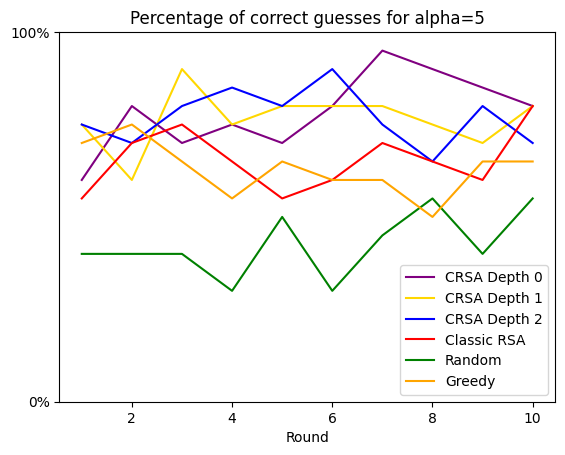

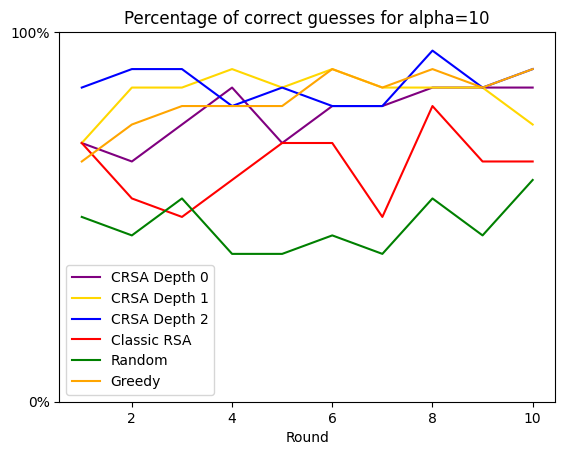

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import logging
from tqdm import tqdm

# Define the logging
date_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logging.basicConfig(filename='logs/output_'+date_string+'.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

for alpha in [0.1,1,5,10]:

        depth_0_results = []
        depth_1_results = []
        depth_2_results = []
        classic_rsa_results = []
        random_results = []
        greedy_results = []

        for number in tqdm(range(10)):

            A_meaning = random.randint(0, len(meanings_A)-1)
            B_meaning = random.randint(0, len(meanings_B)-1)

            # Compute the ground truth ie the position of the A,1 pair
            ground_truth = 0
            for i, char in enumerate(meanings_A[A_meaning]):
                num = meanings_B[B_meaning][i]
                if char == 'A' and num == '1':
                    ground_truth = i+1
            
            # Run the RSA model with a literal Listener and a pragmatic Speaker
            depth_0_estimations, _, _, _ = CRSA(
                initial_lexica = initial_lexica, 
                initial_prior = initial_prior, 
                game_model = game_model, 
                A_meaning = A_meaning, 
                B_meaning = B_meaning, 
                A_utterances = None, 
                B_utterances = None, 
                alpha = alpha, 
                number_of_rounds = 10, 
                RSA_depth = 0, 
                sampling = 'classic', 
                device = device, 
                logging = logging, 
                verbose = False,
                )
            # Run the RSA model with depth 1
            depth_1_estimations, _, _, _ = CRSA(
                initial_lexica = initial_lexica, 
                initial_prior = initial_prior, 
                game_model = game_model, 
                A_meaning = A_meaning, 
                B_meaning = B_meaning, 
                A_utterances = None, 
                B_utterances = None, 
                alpha = alpha, 
                number_of_rounds = 10, 
                RSA_depth = 1, 
                sampling = 'classic', 
                device = device, 
                logging = logging, 
                verbose = False,
                )
            # Run the RSA model with depth 2
            depth_2_estimations, _, _, _ = CRSA(
                initial_lexica = initial_lexica, 
                initial_prior = initial_prior, 
                game_model = game_model, 
                A_meaning = A_meaning, 
                B_meaning = B_meaning, 
                A_utterances = None, 
                B_utterances = None, 
                alpha = alpha, 
                number_of_rounds = 10, 
                RSA_depth = 2, 
                sampling = 'classic', 
                device = device, 
                logging = logging, 
                verbose = False,
                )
            # Run classic RSA on multiple rounds
            classic_rsa_estimations, _, _, _ = multi_classic_RSA(
                initial_lexica = initial_lexica, 
                initial_prior = initial_prior, 
                game_model = game_model, 
                A_meaning = A_meaning, 
                B_meaning = B_meaning, 
                A_utterances = None, 
                B_utterances = None, 
                alpha = alpha, 
                number_of_rounds = 10, 
                RSA_depth = 1, 
                sampling = 'classic', 
                device = device, 
                logging = logging, 
                verbose = False,
                )
            # Run the random model on multiple rounds
            random_estimations, _ = random_model(
                initial_lexica = initial_lexica, 
                initial_prior = initial_prior, 
                game_model = game_model, 
                A_meaning = A_meaning, 
                B_meaning = B_meaning, 
                A_utterances = None, 
                B_utterances = None, 
                number_of_rounds = 10, 
                device = device, 
                logging = logging, 
                verbose = False,
                )
            # Run the greedy model
            greedy_estimations, _ = greedy_model(
                initial_lexica = initial_lexica, 
                initial_prior = initial_prior, 
                game_model = game_model, 
                A_meaning = A_meaning, 
                B_meaning = B_meaning, 
                A_utterances = None, 
                B_utterances = None, 
                alpha = alpha, 
                number_of_rounds = 10, 
                RSA_depth = 1, 
                sampling = 'classic', 
                device = device, 
                logging = logging, 
                verbose = False,
                )

            depth_0_estimations = np.array(depth_0_estimations)
            depth_0_correct_guesses = (depth_0_estimations == ground_truth) * 1

            depth_1_estimations = np.array(depth_1_estimations)
            depth_1_correct_guesses = (depth_1_estimations == ground_truth) * 1

            depth_2_estimations = np.array(depth_2_estimations)
            depth_2_correct_guesses = (depth_2_estimations == ground_truth) * 1

            classic_rsa_estimations = np.array(classic_rsa_estimations)
            classic_rsa_correct_guesses = (classic_rsa_estimations == ground_truth) * 1

            random_estimations = np.array(random_estimations)
            random_correct_guesses = (random_estimations == ground_truth) * 1

            greedy_estimations = np.array(greedy_estimations)
            greedy_correct_guesses = (greedy_estimations == ground_truth) * 1
            
            # Store the results
            depth_0_results.append(depth_0_correct_guesses)
            depth_1_results.append(depth_1_correct_guesses)
            depth_2_results.append(depth_2_correct_guesses)
            classic_rsa_results.append(classic_rsa_correct_guesses)
            random_results.append(random_correct_guesses)
            greedy_results.append(greedy_correct_guesses)
        
        depth_0_results = np.array(depth_0_results)
        depth_1_results = np.array(depth_1_results)
        depth_2_results = np.array(depth_2_results)
        classic_rsa_results = np.array(classic_rsa_results)
        random_results = np.array(random_results)
        greedy_results = np.array(greedy_results)

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Plot the results for CRSA depth 0
        ax.plot(
             range(1, depth_0_results.shape[2]+1), 
             (np.mean(depth_0_results[:, 0, :], axis=0) + np.mean(depth_0_results[:, 1, :], axis=0))/2,
             label='CRSA Depth 0',
             color='purple',
             )

        # Plot the results for CRSA depth 0
        ax.plot(
             range(1, depth_1_results.shape[2]+1), 
             (np.mean(depth_1_results[:, 0, :], axis=0) + np.mean(depth_1_results[:, 1, :], axis=0))/2, 
             label='CRSA Depth 1', 
             color='gold',
             )
        
        # Plot the results for CRSA depth 2
        ax.plot(
             range(1, depth_2_results.shape[2]+1), 
             (np.mean(depth_2_results[:, 0, :], axis=0) + np.mean(depth_2_results[:, 1, :], axis=0))/2, 
             label='CRSA Depth 2', 
             color='blue',
             )
        
        # Plot the results for multi-turns classic RSA
        ax.plot(
             range(1, classic_rsa_results.shape[2]+1), 
             (np.mean(classic_rsa_results[:, 0, :], axis=0) + np.mean(classic_rsa_results[:, 1, :], axis=0))/2, 
             label='Classic RSA', 
             color='red',
             )
        
        # Plot the results for random
        ax.plot(
             range(1, random_results.shape[2]+1), 
             (np.mean(random_results[:, 0, :], axis=0) + np.mean(random_results[:, 1, :], axis=0))/2, 
             label='Random', 
             color='green',
             )
        
        # Plot the results for greedy
        ax.plot(
             range(1, greedy_results.shape[2]+1), 
             (np.mean(greedy_results[:, 0, :], axis=0) + np.mean(greedy_results[:, 1, :], axis=0))/2, 
             label='Greedy', 
             color='orange',
             )

        # Set the labels and title
        ax.set_xlabel('Round')
        ax.set_title(f'Percentage of correct guesses for alpha={alpha}')

        # Set the y-axis ticks and labels
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0%', '100%'])

        # Add a legend
        ax.legend()

        # Save the plot as a file
        os.makedirs(f'plots_toy_example/{date_string}', exist_ok=True)
        plt.savefig(f'plots_toy_example/{date_string}/alpha_{alpha}_average.png', bbox_inches='tight')

In [ ]:
from RSA import run_RSA

run_RSA(world, version="RSA", alpha=1, depth=1, verbose=False):
run_RSA()

### Plot the results of the toy example

Agent A observes: BAA / id=0.
Agent B observes: 212 / id=2.
Round: 0
Utterance of Agent A: 3rd position
Estimated truth by a pragmatic Agent B: There is no (A,1) pair
Utterance of Agent B: 2nd position
Estimated truth by a pragmatic Agent A: 2nd position
Round: 1
Utterance of Agent A: 2nd position
Estimated truth by a pragmatic Agent B: 2nd position
Utterance of Agent B: 2nd position
Estimated truth by a pragmatic Agent A: 2nd position
Round: 2
Utterance of Agent A: 3rd position
Estimated truth by a pragmatic Agent B: 2nd position
Utterance of Agent B: 2nd position
Estimated truth by a pragmatic Agent A: 2nd position


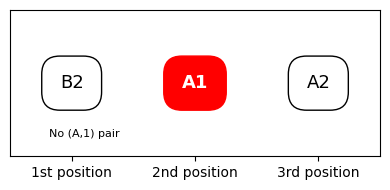

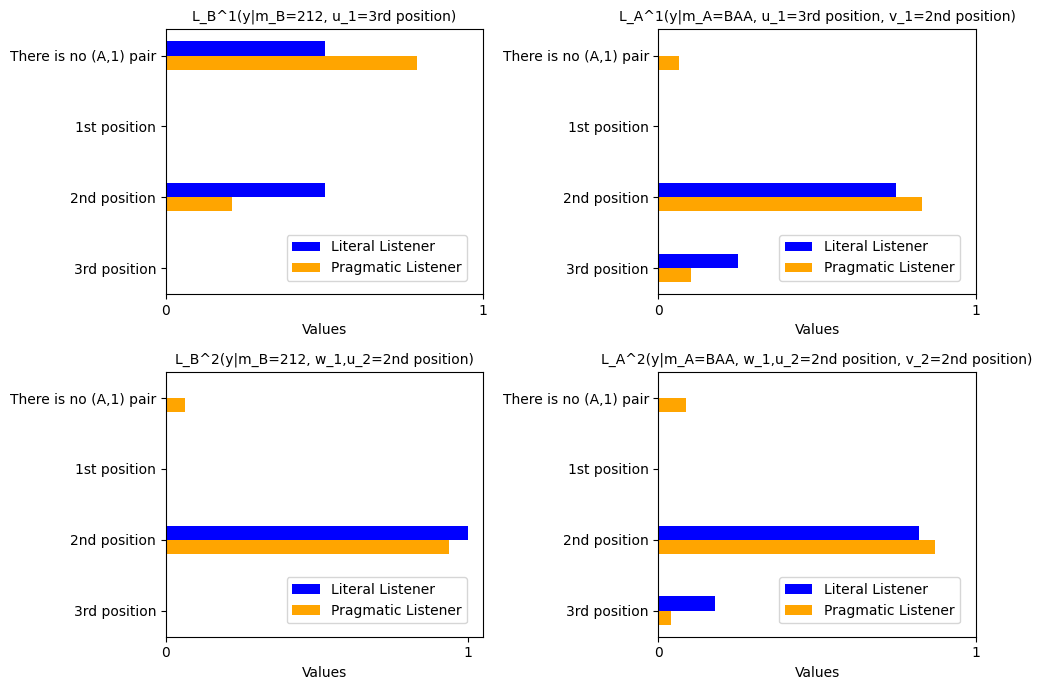

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

A_meaning = random.randint(0, len(meanings_A)-1)
B_meaning = random.randint(0, len(meanings_B)-1)
A_meaning = 0
B_meaning = 2

alpha = 1
estimations, produced_utterances, literal_listeners, pragmatic_speakers, pragmatic_listeners = CRSA(initial_lexica, initial_prior, game_model, A_meaning, B_meaning, A_utterances, B_utterances, alpha, number_of_rounds, 1, deterministic, device, logging, verbose)

A_meaning_str = meanings_A[A_meaning]
B_meaning_str = meanings_B[B_meaning]

# Define the underlined red text style
underline_red = dict(facecolor='red', edgecolor='red', boxstyle='round,pad=1', )
underline_black = dict(facecolor='None', edgecolor='black', boxstyle='round,pad=1', )

# Plot the scenarios
fig, axs = plt.subplots(1, 1, figsize=(4, 2))

is_goal = False

ax = axs
for x in range(3):
    char, num = A_meaning_str[x], B_meaning_str[x]
    if char == 'A' and num == '1':
        is_goal = True
        ax.text(x, 0, char + num, color='white', size=13, fontweight='bold', ha='center', va='center', bbox=underline_red)
    else:
        ax.text(x, 0, char + num, color='black', size=13, ha='center', va='center', bbox=underline_black)
    ax.plot(x, 0, markersize=13)  # Flip the y-axis
if not is_goal:
    ax.text(0.1, -0.35, "No (A,1) pair", color='white', size=8, ha='center', va='center', bbox=underline_red)
else:
    ax.text(0.1, -0.35, "No (A,1) pair", color='black', size=8, ha='center', va='center')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([-0.5, 0.5])  # Adjust the y-axis limits
ax.set_xticks(range(3))
ax.set_yticks([])  # Adjust the y-axis ticks
ax.set_xticklabels(['1st position', '2nd position', '3rd position'])
ax.grid(False)

plt.tight_layout()
plt.show()

def plot_listener_subplot(ax, literal_listener, pragmatic_listener, worlds, title):
    y_pos = np.arange(len(worlds))
    width = 0.2  # Width of the bars

    ax.barh(y_pos - width/2, literal_listener, height=width, align='center', color='blue', label='Literal Listener')
    ax.barh(y_pos + width/2, pragmatic_listener, height=width, align='center', color='orange', label='Pragmatic Listener')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(worlds)
    ax.invert_yaxis()  # Invert the y-axis to have the top bar at the top
    ax.set_xticks([0,1])
    ax.set_xlabel('Values')
    ax.set_title(title, fontsize=10, fontname='Arial')
    ax.legend(bbox_to_anchor=(0.95, 0.05), loc='lower right', borderaxespad=0.)

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

w_string = ""

for i in range(2):
    u_id = produced_utterances[0][i]
    v_id = produced_utterances[1][i]
    u = utterances_A[u_id]
    v = utterances_B[v_id]
    # Listener B
    w_string += f"u_{i+1}={u}"
    title = f'L_B^{i+1}(y|m_B={B_meaning_str}, '+ w_string +')'
    plot_listener_subplot(axs[i, 0], literal_listeners[1][i][:,u_id].cpu().numpy(), pragmatic_listeners[1][i][:,u_id].cpu().numpy(), Y, title)
    # Listener A
    w_string += f", v_{i+1}={v}"
    title = f'L_A^{i+1}(y|m_A={A_meaning_str}, '+ w_string +')'
    plot_listener_subplot(axs[i, 1], literal_listeners[0][i][:,v_id].cpu().numpy(), pragmatic_listeners[0][i][:,v_id].cpu().numpy(), Y, title)

    w_string = f"w_{i+1},"

plt.tight_layout()
plt.show()


In [15]:
from RSA import multi_classic_RSA
import torch
import random
import logging
import datetime

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model of the game
meanings_A = ["BAA", "ABA", "ABB", "BAB", "BBA"]
meanings_B = ["112", "221", "212", "122"]
utterances_A = ["1st position", "2nd position", "3rd position"]
utterances_B = ["1st position", "2nd position", "3rd position"]
Y = ["There is no (A,1) pair", "1st position", "2nd position", "3rd position"] # the question we try to answer is what is the position of the A,1 pair.

'''
# Define the prior
prior = torch.tensor([
    [[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0]],
    [[0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0]],
    [[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0]],
    [[0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0]],
    [[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]],
    ], device=device, dtype=torch.float32)

initial_prior = prior * 1/len(meanings_A) * 1/len(meanings_B)

# Define the lexica
lexicon_A = torch.tensor([
    [0, 1, 1], 
    [1, 0, 1], 
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    ], device=device, dtype=torch.float32)

lexicon_B = torch.tensor([
    [1, 1, 0], 
    [0, 0, 1], 
    [0, 1, 0],
    [1, 0, 0],
    ], device=device, dtype=torch.float32)
'''

full_meanings_A = ['BAA', 'ABA', 'ABB', 'BAB', 'BBA', 'AAA', 'AAB', 'BBB']
full_meanings_B = ['112', '221', '212', '122', '111', '121', '211', '222']

game_model = {"mA": full_meanings_A, "mB": full_meanings_B, "u": utterances_A, "v": utterances_B, "y": Y}

prior = torch.zeros((len(full_meanings_A), len(full_meanings_B), len(Y)), device=device, dtype=torch.float)

for i, mA in enumerate(full_meanings_A):
    for j, mB in enumerate(full_meanings_B):
        for k, y in enumerate(Y):
            intersect = set(id for id, char in enumerate(mA) if char == 'A').intersection(set(id for id, num in enumerate(mB) if num == '1'))
            if not intersect:
                prior[i,j,0] = 1
            else:
                for id in intersect:
                    prior[i,j,id+1] = 1
            prior[i,j] = prior[i,j] / prior[i,j].sum()

initial_prior = prior * 1/len(full_meanings_A) * 1/len(full_meanings_B)

lexicon_A = torch.zeros((len(full_meanings_A), len(utterances_A)), device=device, dtype=torch.float)
for i, mA in enumerate(full_meanings_A):
    for j, uA in enumerate(utterances_A):
        if j in set(id for id, char in enumerate(mA) if char == 'A'):
            lexicon_A[i,j] = 1

lexicon_B = torch.zeros((len(full_meanings_B), len(utterances_B)), device=device, dtype=torch.float)
for i, mB in enumerate(full_meanings_B):
    for j, uB in enumerate(utterances_B):
        if j in set(id for id, num in enumerate(mB) if num == '1'):
            lexicon_B[i,j] = 1

initial_lexica = [lexicon_A, lexicon_B]

# Fix the meanings observed by the agents
A_meaning = random.randint(0, len(meanings_A)-1)
B_meaning = random.randint(0, len(meanings_B)-1)

A_meaning = 1
B_meaning = 3

# Fix the utterances observed by the agents
# A_utterances = [1, 1, 1, 1]
A_utterances = None
B_utterances = None

# Define the parameters
alpha = 1
number_of_rounds = 3
RSA_depth = 1
verbose = True
sampling = "classic"

# Define the logging
date_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logging.basicConfig(filename='logs/output_'+date_string+'.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Run the Interactive RSA
estimations, produced_utterances, last_speakers, last_listeners = multi_classic_RSA(
    initial_lexica = initial_lexica, 
    initial_prior = initial_prior, 
    game_model = game_model, 
    A_meaning = A_meaning, 
    B_meaning = B_meaning, 
    A_utterances = A_utterances, 
    B_utterances = B_utterances, 
    alpha = alpha, 
    number_of_rounds = number_of_rounds, 
    RSA_depth = RSA_depth, 
    sampling = sampling, 
    device = device, 
    logging = logging, 
    verbose = verbose,
    )

Using device: cuda
Agent A observes: ABA / id=1.
Agent B observes: 122 / id=3.
Utterance of Agent A: 1st position
Estimation of Agent B: 1st position
Utterance of Agent B: 1st position
Estimation of Agent A: 1st position
Utterance of Agent A: 1st position
Estimation of Agent B: 1st position
Utterance of Agent B: 1st position
Estimation of Agent A: 1st position
Utterance of Agent A: 3rd position
Estimation of Agent B: There is no (A,1) pair
Utterance of Agent B: 1st position
Estimation of Agent A: 1st position


# "Planning, Inference and Pragmatics"'s data

### Load data

In [ ]:
import pandas as pd

# Read the CSV file
df_message = pd.read_csv('planning_inference/data/message_cleaned.csv')
df_clickedObj = pd.read_csv('planning_inference/data/clickedObj_cleaned.csv')
df_games = pd.read_csv('planning_inference/data/game_properties_cleaned.csv')

### Create the scenarios set i.e. the real worlds (from which agent's specific observations are derived)

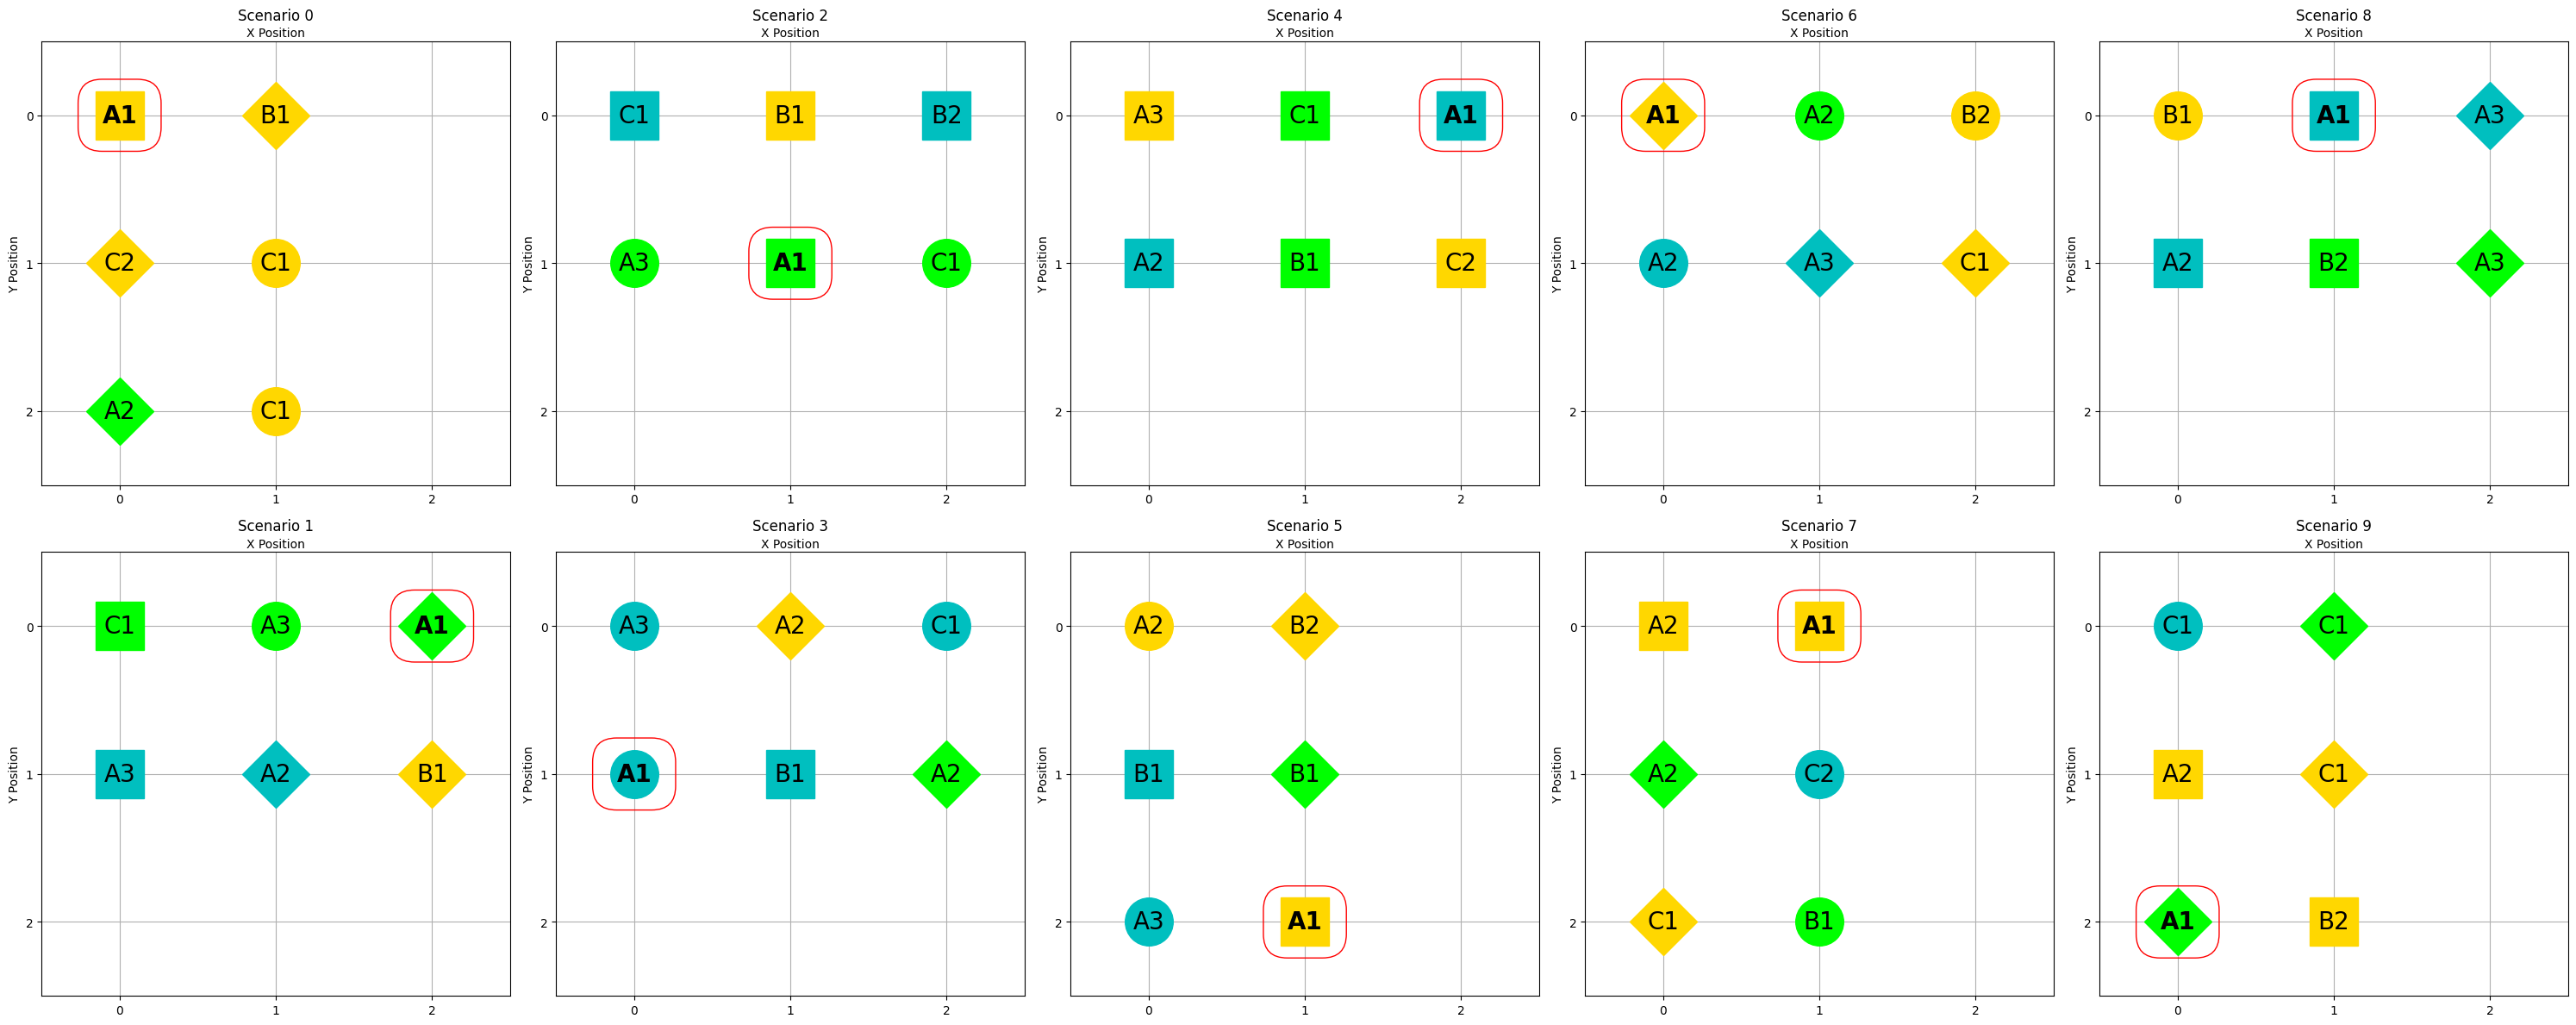

In [ ]:
import matplotlib.pyplot as plt

# scenarios = {'0,0,circle,cyan,A,1,0/0,1,rect,yellow,C,2,0/...', ...}
scenarios = {}
numero = 0
for gameid_roundNum in df_games['gameid_roundNum'].unique():
    scenario_key = ""
    for row in df_games[df_games['gameid_roundNum'] == gameid_roundNum].iterrows():
        if scenario_key != "":
            scenario_key += "/"
        scenario_key += str(row[1]['pos_x']) + "," + str(row[1]['pos_y']) + "," + str(row[1]['shape']) + "," + str(row[1]['color']) + "," + str(row[1]['char']) + "," + str(row[1]['num']) + "," + str(row[1]['goal'])
    if scenario_key not in scenarios:
        scenarios[scenario_key] = numero
        numero += 1

# Define the colors and shapes
colors = {'cyan': 'c', 'Chartreuse': 'lime', 'yellow': 'gold'}
shapes = {'rect': 's', 'circle': 'o', 'diamond': 'D'}

# Define the positions
positions = {
    '0,0': (0, 0),
    '0,1': (0, 1),
    '0,2': (0, 2),
    '1,0': (1, 0),
    '1,1': (1, 1),
    '1,2': (1, 2),
    '2,0': (2, 0),
    '2,1': (2, 1),
    '2,2': (2, 2)
}

# Define the underlined red text style
underline_red = dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1')

# Plot the scenarios
fig, axs = plt.subplots(2, len(scenarios)//2, figsize=(6*len(scenarios)//2, 12))

for i, scenario in enumerate(scenarios):
    ax = axs[i%2, i//2]
    objects = scenario.split('/')
    for obj in objects:
        x, y, shape, color, char, num, goal = obj.split(',')
        pos = positions[x + ',' + y]
        if goal == '1':
            ax.text(pos[0], - pos[1], char + num, color='black', size=20, fontweight='bold', ha='center', va='center', bbox=underline_red)
        else:
            ax.text(pos[0], - pos[1], char + num, color='black', size=20, ha='center', va='center')
        ax.plot(pos[0], -pos[1], marker=shapes[shape], color=colors[color], markersize=40)  # Flip the y-axis
    ax.set_xlim([-0.5, 2.5])
    ax.set_ylim([-2.5, 0.5])  # Adjust the y-axis limits
    ax.set_xticks(range(3))
    ax.set_yticks(range(-2, 1))  # Adjust the y-axis ticks
    ax.set_xticklabels(['0', '1', '2'])
    ax.set_yticklabels(['2', '1', '0'])  # Adjust the y-axis tick labels
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.xaxis.set_label_position('top')
    ax.set_title('Scenario ' + str(scenarios[scenario]))
    ax.grid(True)

plt.tight_layout()
plt.show()


These are the possible scenarios in the dataset. However, in order to respect the true situation, we need to consider all possible scenarios that could have happened from each agent's perspective. Each agent sees the sames shapes, positions and colors, but P_numbers (resp P_characters) ignore the characterss (resp numbers). They also ignore the objectives. From the 10 scenarios above, we thus need to infer all possible scenarios to have complete versions of $M_A$ and $M_B$. $Y$ is only the set of all possible positions for the $A,1$ pair: $Y = \{\text{"There is no A,1 pair", "The A,1 pair is in the 1st position", ...}\}$.

In [ ]:
from itertools import product
import torch

letters_combinations = list(product('ABC', repeat=6))
numbers_combinations = list(product('123', repeat=6))

Y = ["There is no (A,1) pair", "The (A,1) pair is in 1st position", "The (A,1) pair is in 2nd position", "The (A,1) pair is in 3rd position"] + [f"The (A,1) pair is in {x}th position" for x in range(4,7)]  # the objective will be different from all scenarios. They will be the same as the original scenario they are derived from (eg scenarios derived from scenario 0 will have as objective to find a A3 pair)

meanings_A = []
meanings_B = []

for letters_combination in letters_combinations:
    for scenario in scenarios:
        A_meaning = ""
        objects = scenario.split('/')
        for i, obj in enumerate(objects):
            if A_meaning != "":
                A_meaning += "/"
            x, y, shape, color, char, num, goal = obj.split(',')
            A_meaning += x + ',' + y + ',' + shape + ',' + color + ',' + letters_combination[i]
        if A_meaning in meanings_A:
            print(f"Warning: A_meaning already in meanings_A - {letters_combination} - {scenario}")
        meanings_A.append(A_meaning)

for numbers_combination in numbers_combinations:
    for scenario in scenarios:
        B_meaning = ""
        objects = scenario.split('/')
        for i, obj in enumerate(objects):
            if B_meaning != "":
                B_meaning += "/"
            x, y, shape, color, char, num, goal = obj.split(',')
            B_meaning += x + ',' + y + ',' + shape + ',' + color + ',' + numbers_combination[i]
        if B_meaning in meanings_B:
            print(f"Warning: B_meaning already in meanings_B - {numbers_combination} - {scenario}")
        meanings_B.append(B_meaning)

print(len(Y))
print(len(meanings_A))
print(len(meanings_B))

7
7290
7290


In [ ]:
ids_scenario = {scenario: [] for scenario in list(scenarios.keys())}

for scenario in list(scenarios.keys()):
    objects = scenario.split('/')
    scenario_to_meaning_A = ""
    scenario_to_meaning_B = ""
    for obj in objects:
        if scenario_to_meaning_A != "":
            scenario_to_meaning_A += "/"
            scenario_to_meaning_B += "/"
        x, y, shape, color, char, num, goal = obj.split(',')
        scenario_to_meaning_A += x + ',' + y + ',' + shape + ',' + color + ',' + char
        scenario_to_meaning_B += x + ',' + y + ',' + shape + ',' + color + ',' + num
    for meaning in meanings_A:
        if meaning == scenario_to_meaning_A:
            ids_scenario[scenario].append(meanings_A.index(meaning))
    for meaning in meanings_B:
        if meaning == scenario_to_meaning_B:
            ids_scenario[scenario].append(meanings_B.index(meaning))       

scenario = list(scenarios.keys())[0]
print(f"Scenario: {scenario}")
print(f"A's view: {meanings_A[ids_scenario[scenario][0]]}") 
print(f"B's view: {meanings_B[ids_scenario[scenario][1]]}")

Scenario: 0,0,rect,yellow,A,1,1/0,1,diamond,yellow,C,2,0/0,2,diamond,Chartreuse,A,2,0/1,0,diamond,yellow,B,1,0/1,1,circle,yellow,C,1,0/1,2,circle,yellow,C,1,0
A's view: 0,0,rect,yellow,A/0,1,diamond,yellow,C/0,2,diamond,Chartreuse,A/1,0,diamond,yellow,B/1,1,circle,yellow,C/1,2,circle,yellow,C
B's view: 0,0,rect,yellow,1/0,1,diamond,yellow,2/0,2,diamond,Chartreuse,2/1,0,diamond,yellow,1/1,1,circle,yellow,1/1,2,circle,yellow,1


In [ ]:
from tqdm import tqdm
import torch.sparse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prior = torch.zeros((len(meanings_A), len(meanings_B), 7), device=device, dtype=torch.float32)

for A_meaning in tqdm(meanings_A):
    for B_meaning in meanings_B:
        A_objects = A_meaning.split('/')
        B_objects = B_meaning.split('/')
        one_objective_pos = False
        for i, A_obj in enumerate(A_objects):
            B_obj = B_objects[i]
            char = A_obj[-1]
            num = B_obj[-1]
            if char == 'A' and num == '1':
                if not one_objective_pos:
                    prior[meanings_A.index(A_meaning), meanings_B.index(B_meaning), i+1] = 1
                    one_objective_pos = True
                else: # if there is more than one (A,1) pair, the prior is 0 because m_A and m_B are thus not compatible
                    prior[meanings_A.index(A_meaning), meanings_B.index(B_meaning), :] = 0
                    break
        if not one_objective_pos:
            prior[meanings_A.index(A_meaning), meanings_B.index(B_meaning), 0] = 1
prior = prior / prior.sum()
torch.save(prior, 'planning_inference/data/prior.pt')

  0%|          | 0/7290 [00:00<?, ?it/s]

100%|██████████| 7290/7290 [2:27:03<00:00,  1.21s/it]  


In [ ]:
prior = torch.load('planning_inference/data/prior.pt')

### Create the utterance set

In [ ]:
from itertools import combinations

# Listing the used words
words = df_message['contents'].str.split()
words_flat = [word.lower() for sublist in words for word in sublist] + ['']
used_words = set(words_flat)
print("Used words:", used_words)

# Creating the utterance set
utterances = list(combinations(used_words, 2))
print("Utterance set:", utterances)

Used words: {'', 'green', 'circle', 'top', 'bottom', 'middle', 'square', 'right', 'diamond', 'yellow', 'blue', 'not', 'left'}
Utterance set: [('', 'green'), ('', 'circle'), ('', 'top'), ('', 'bottom'), ('', 'middle'), ('', 'square'), ('', 'right'), ('', 'diamond'), ('', 'yellow'), ('', 'blue'), ('', 'not'), ('', 'left'), ('green', 'circle'), ('green', 'top'), ('green', 'bottom'), ('green', 'middle'), ('green', 'square'), ('green', 'right'), ('green', 'diamond'), ('green', 'yellow'), ('green', 'blue'), ('green', 'not'), ('green', 'left'), ('circle', 'top'), ('circle', 'bottom'), ('circle', 'middle'), ('circle', 'square'), ('circle', 'right'), ('circle', 'diamond'), ('circle', 'yellow'), ('circle', 'blue'), ('circle', 'not'), ('circle', 'left'), ('top', 'bottom'), ('top', 'middle'), ('top', 'square'), ('top', 'right'), ('top', 'diamond'), ('top', 'yellow'), ('top', 'blue'), ('top', 'not'), ('top', 'left'), ('bottom', 'middle'), ('bottom', 'square'), ('bottom', 'right'), ('bottom', 'diamo

### Create the lexicon

In [ ]:
def word_meaning_correspondancy(word, meaning):
    '''
    Gives the semantic correspondancy between a word and a meaning.
    The list of words chosen are the 12 most used words in the experiments led by Khani et al in "Planing, Inference and Pragmatics in Sequential Language Games". 
    The word 'not' is not present here as it is never alone and always negates the meaning of the word that follows it.
    '''
    objects = meaning.split('/')
    res = torch.zeros((len(objects)), dtype=torch.bool)
    if word == '':
        return res + 1
    if word == 'green':
        for i, obj in enumerate(objects):
            if ('Chartreuse' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'yellow':
        for i, obj in enumerate(objects):
            if ('yellow' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'blue':
        for i, obj in enumerate(objects):
            if ('cyan' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'circle':
        for i, obj in enumerate(objects):
            if ('circle' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'square':
        for i, obj in enumerate(objects):
            if ('rect' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'diamond':
        for i, obj in enumerate(objects):
            if ('diamond' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'left':
        for i, obj in enumerate(objects):
            if ('0' == obj[0]):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'middle':
        for i, obj in enumerate(objects):
            if (('1' == obj[0] and any('2' == obj_bis[0] for obj_bis in objects)) or ('1' == obj[2] and any('2' == obj_bis[2] for obj_bis in objects))):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'right':
        for i, obj in enumerate(objects):
            if (('2' == obj[0]) or (not any('2' == obj_bis[0] for obj_bis in objects) and '1' == obj[0])):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'top':
        for i, obj in enumerate(objects):
            if ('0' == obj[2]):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'bottom':
        for i, obj in enumerate(objects):
            if (('2' == obj[2]) or (not any('2' == obj_bis[2] for obj_bis in objects) and '1' == obj[2])):
                res[i] = 1
            else:
                res[i] = 0
    return res

In [ ]:
target_vector = torch.zeros((6), dtype=torch.bool)
target_vector[0] = 1
target_vector[1] = 1
A = torch.zeros((6), dtype=torch.bool)
A[1] = 1
B = torch.zeros((6), dtype=torch.bool)
B[2] = 1
target_vector * ((torch.max(A, B) + 1)%2)

tensor([1, 0, 0, 1, 1, 1])

In [ ]:
def utterance_meaning_correspondancy(utterance, meaning):
    '''
    Gives the semantic correspondancy between a meaning and a message (composed of two words among the 12 most used in the experiments led by Khani et al in "Planing, Inference and Pragmatics in Sequential Language Games".
    '''
    colors = {'blue', 'green', 'yellow'}
    horizontal = {'left', 'middle', 'right'}
    vertical = {'top', 'middle', 'bottom'}
    shapes = {'diamond', 'square', 'circle'}

    objects = meaning.split('/')
    target_vector = torch.zeros((len(objects)), dtype=torch.bool)
    for i, obj in enumerate(objects):
        target_vector[i] = (obj[-1] in {'1','A'})

    if 'not' in utterance: # if 'not' in the message, the other word is negated
        not_id = utterance.index('not')
        return torch.all((target_vector * (word_meaning_correspondancy(utterance[(not_id + 1) % 2], meaning) + 1) % 2)[target_vector==1]).item()
    
    elif any(utterance[0] in same_group and utterance[1] in same_group for same_group in [colors, horizontal, vertical, shapes]): # if both words are mutually exclusive, we interpret the message as "word 1" or "word 2"
        return torch.any(target_vector * torch.max(word_meaning_correspondancy(utterance[0], meaning), word_meaning_correspondancy(utterance[1], meaning))).item()
    
    else: # if the words are not mutually exclusive, we interpret the message as "word 1" and "word 2"
        return torch.any(target_vector * word_meaning_correspondancy(utterance[0], meaning) * word_meaning_correspondancy(utterance[1], meaning)).item()

# Test the function
meaning = '0,0,rect,yellow,A/0,1,diamond,yellow,C/0,2,diamond,Chartreuse,A/1,0,diamond,yellow,B/1,1,circle,yellow,C/1,2,circle,yellow,C'
print(meaning)
for utterance in utterances:
    print(utterance, utterance_meaning_correspondancy(utterance, meaning))

0,0,rect,yellow,A/0,1,diamond,yellow,C/0,2,diamond,Chartreuse,A/1,0,diamond,yellow,B/1,1,circle,yellow,C/1,2,circle,yellow,C
('', 'diamond') True
('', 'green') True
('', 'bottom') True
('', 'square') True
('', 'yellow') True
('', 'not') False
('', 'left') True
('', 'circle') False
('', 'middle') False
('', 'right') False
('', 'blue') False
('', 'top') True
('diamond', 'green') True
('diamond', 'bottom') True
('diamond', 'square') True
('diamond', 'yellow') False
('diamond', 'not') False
('diamond', 'left') True
('diamond', 'circle') True
('diamond', 'middle') False
('diamond', 'right') False
('diamond', 'blue') False
('diamond', 'top') False
('green', 'bottom') True
('green', 'square') False
('green', 'yellow') True
('green', 'not') False
('green', 'left') True
('green', 'circle') False
('green', 'middle') False
('green', 'right') False
('green', 'blue') True
('green', 'top') False
('bottom', 'square') False
('bottom', 'yellow') False
('bottom', 'not') False
('bottom', 'left') True
('b

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lexicon_A = torch.zeros((len(meanings_A), len(utterances)), device=device, dtype=torch.float32)
lexicon_B = torch.zeros((len(meanings_B), len(utterances)), device=device, dtype=torch.float32)

for j, utterance in tqdm(enumerate(utterances)):
    for i, meaning in enumerate(meanings_A):
        lexicon_A[i, j] = utterance_meaning_correspondancy(utterance, meaning)
    for i, meaning in enumerate(meanings_B):
        lexicon_B[i, j] = utterance_meaning_correspondancy(utterance, meaning)

78it [01:06,  1.17it/s]


### Model the game

In [ ]:
from main import main

# Model of the game
game_model = {"mA": meanings_A, "mB": meanings_B, "u": utterances, "v": utterances, "y": Y}

initial_lexica = [lexicon_A, lexicon_B]

scenario = list(scenarios.keys())[0]
A_meaning = ids_scenario[scenario][0]
B_meaning = ids_scenario[scenario][1]

main(initial_lexica, prior, game_model, A_meaning, B_meaning, None, None, 2, 4, 1, device, True)

Agent A observes: 0,0,rect,yellow,A/0,1,diamond,yellow,C/0,2,diamond,Chartreuse,A/1,0,diamond,yellow,B/1,1,circle,yellow,C/1,2,circle,yellow,C / id=1790.
Agent B observes: 0,0,rect,yellow,1/0,1,diamond,yellow,2/0,2,diamond,Chartreuse,2/1,0,diamond,yellow,1/1,1,circle,yellow,1/1,2,circle,yellow,1 / id=1080.
Round: 0
Utterance of Agent A: ('top', 'left')
Estimated meaning by Agent B: The (A,1) pair is in 1st position
Utterance of Agent B: ('top', 'right')
Estimated meaning by Agent A: There is no (A,1) pair
Round: 1
Utterance of Agent A: ('right', 'not')
Estimated meaning by Agent B: The (A,1) pair is in 1st position
Utterance of Agent B: ('circle', 'top')
Estimated meaning by Agent A: The (A,1) pair is in 1st position
Round: 2
Utterance of Agent A: ('green', 'circle')
Estimated meaning by Agent B: The (A,1) pair is in 1st position
Utterance of Agent B: ('square', 'right')
Estimated meaning by Agent A: The (A,1) pair is in 1st position
Round: 3
Utterance of Agent A: ('bottom', 'not')
Est

### Run the following once for all

In [ ]:
from tqdm import tqdm
from itertools import combinations
from itertools import product
import torch
import pandas as pd

# Read the CSV file
df_message = pd.read_csv('planning_inference/data/message_cleaned.csv')
df_clickedObj = pd.read_csv('planning_inference/data/clickedObj_cleaned.csv')
df_games = pd.read_csv('planning_inference/data/game_properties_cleaned.csv')


# scenarios = {'0,0,circle,cyan,A,1,0/0,1,rect,yellow,C,2,0/...', ...}
scenarios = {}
numero = 0
for gameid_roundNum in df_games['gameid_roundNum'].unique():
    scenario_key = ""
    for row in df_games[df_games['gameid_roundNum'] == gameid_roundNum].iterrows():
        if scenario_key != "":
            scenario_key += "/"
        scenario_key += str(row[1]['pos_x']) + "," + str(row[1]['pos_y']) + "," + str(row[1]['shape']) + "," + str(row[1]['color']) + "," + str(row[1]['char']) + "," + str(row[1]['num']) + "," + str(row[1]['goal'])
    if scenario_key not in scenarios:
        scenarios[scenario_key] = numero
        numero += 1


letters_combinations = list(product('ABC', repeat=6))
numbers_combinations = list(product('123', repeat=6))

Y = ["There is no (A,1) pair", "The (A,1) pair is in 1st position", "The (A,1) pair is in 2nd position", "The (A,1) pair is in 3rd position"] + [f"The (A,1) pair is in {x}th position" for x in range(4,7)]  # the objective will be different from all scenarios. They will be the same as the original scenario they are derived from (eg scenarios derived from scenario 0 will have as objective to find a A3 pair)

meanings_A = []
meanings_B = []

for letters_combination in letters_combinations:
    for scenario in scenarios:
        A_meaning = ""
        objects = scenario.split('/')
        for i, obj in enumerate(objects):
            if A_meaning != "":
                A_meaning += "/"
            x, y, shape, color, char, num, goal = obj.split(',')
            A_meaning += x + ',' + y + ',' + shape + ',' + color + ',' + letters_combination[i]
        if A_meaning in meanings_A:
            print(f"Warning: A_meaning already in meanings_A - {letters_combination} - {scenario}")
        meanings_A.append(A_meaning)

for numbers_combination in numbers_combinations:
    for scenario in scenarios:
        B_meaning = ""
        objects = scenario.split('/')
        for i, obj in enumerate(objects):
            if B_meaning != "":
                B_meaning += "/"
            x, y, shape, color, char, num, goal = obj.split(',')
            B_meaning += x + ',' + y + ',' + shape + ',' + color + ',' + numbers_combination[i]
        if B_meaning in meanings_B:
            print(f"Warning: B_meaning already in meanings_B - {numbers_combination} - {scenario}")
        meanings_B.append(B_meaning)


ids_scenario = {scenario: [] for scenario in list(scenarios.keys())}

for scenario in list(scenarios.keys()):
    objects = scenario.split('/')
    scenario_to_meaning_A = ""
    scenario_to_meaning_B = ""
    for obj in objects:
        if scenario_to_meaning_A != "":
            scenario_to_meaning_A += "/"
            scenario_to_meaning_B += "/"
        x, y, shape, color, char, num, goal = obj.split(',')
        scenario_to_meaning_A += x + ',' + y + ',' + shape + ',' + color + ',' + char
        scenario_to_meaning_B += x + ',' + y + ',' + shape + ',' + color + ',' + num
    for meaning in meanings_A:
        if meaning == scenario_to_meaning_A:
            ids_scenario[scenario].append(meanings_A.index(meaning))
    for meaning in meanings_B:
        if meaning == scenario_to_meaning_B:
            ids_scenario[scenario].append(meanings_B.index(meaning))       

scenario = list(scenarios.keys())[0]

prior = torch.load('planning_inference/data/prior.pt')

# Listing the used words
words = df_message['contents'].str.split()
words_flat = [word.lower() for sublist in words for word in sublist] + ['']
used_words = set(words_flat)
print("Used words:", used_words)

# Creating the utterance set
utterances = list(combinations(used_words, 2))
print("Utterance set:", utterances)



def word_meaning_correspondancy(word, meaning):
    '''
    Gives the semantic correspondancy between a word and a meaning.
    The list of words chosen are the 12 most used words in the experiments led by Khani et al in "Planing, Inference and Pragmatics in Sequential Language Games". 
    The word 'not' is not present here as it is never alone and always negates the meaning of the word that follows it.
    '''
    objects = meaning.split('/')
    res = torch.zeros((len(objects)), dtype=torch.bool)
    if word == '':
        return res + 1
    if word == 'green':
        for i, obj in enumerate(objects):
            if ('Chartreuse' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'yellow':
        for i, obj in enumerate(objects):
            if ('yellow' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'blue':
        for i, obj in enumerate(objects):
            if ('cyan' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'circle':
        for i, obj in enumerate(objects):
            if ('circle' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'square':
        for i, obj in enumerate(objects):
            if ('rect' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'diamond':
        for i, obj in enumerate(objects):
            if ('diamond' in obj):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'left':
        for i, obj in enumerate(objects):
            if ('0' == obj[0]):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'middle':
        for i, obj in enumerate(objects):
            if (('1' == obj[0] and any('2' == obj_bis[0] for obj_bis in objects)) or ('1' == obj[2] and any('2' == obj_bis[2] for obj_bis in objects))):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'right':
        for i, obj in enumerate(objects):
            if (('2' == obj[0]) or (not any('2' == obj_bis[0] for obj_bis in objects) and '1' == obj[0])):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'top':
        for i, obj in enumerate(objects):
            if ('0' == obj[2]):
                res[i] = 1
            else:
                res[i] = 0
    elif word == 'bottom':
        for i, obj in enumerate(objects):
            if (('2' == obj[2]) or (not any('2' == obj_bis[2] for obj_bis in objects) and '1' == obj[2])):
                res[i] = 1
            else:
                res[i] = 0
    return res



def utterance_meaning_correspondancy(utterance, meaning):
    '''
    Gives the semantic correspondancy between a meaning and a message (composed of two words among the 12 most used in the experiments led by Khani et al in "Planing, Inference and Pragmatics in Sequential Language Games".
    '''
    colors = {'blue', 'green', 'yellow'}
    horizontal = {'left', 'middle', 'right'}
    vertical = {'top', 'middle', 'bottom'}
    shapes = {'diamond', 'square', 'circle'}

    objects = meaning.split('/')
    target_vector = torch.zeros((len(objects)), dtype=torch.bool)
    for i, obj in enumerate(objects):
        target_vector[i] = (obj[-1] in {'1','A'})

    if 'not' in utterance: # if 'not' in the message, the other word is negated
        not_id = utterance.index('not')
        return torch.all((target_vector * (word_meaning_correspondancy(utterance[(not_id + 1) % 2], meaning) + 1) % 2)[target_vector==1]).item()
    
    elif any(utterance[0] in same_group and utterance[1] in same_group for same_group in [colors, horizontal, vertical, shapes]): # if both words are mutually exclusive, we interpret the message as "word 1" or "word 2"
        return torch.any(target_vector * torch.max(word_meaning_correspondancy(utterance[0], meaning), word_meaning_correspondancy(utterance[1], meaning))).item()
    
    else: # if the words are not mutually exclusive, we interpret the message as "word 1" and "word 2"
        return torch.any(target_vector * word_meaning_correspondancy(utterance[0], meaning) * word_meaning_correspondancy(utterance[1], meaning)).item()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lexicon_A = torch.zeros((len(meanings_A), len(utterances)), device=device, dtype=torch.float32)
lexicon_B = torch.zeros((len(meanings_B), len(utterances)), device=device, dtype=torch.float32)

for j, utterance in tqdm(enumerate(utterances)):
    for i, meaning in enumerate(meanings_A):
        lexicon_A[i, j] = utterance_meaning_correspondancy(utterance, meaning)
    for i, meaning in enumerate(meanings_B):
        lexicon_B[i, j] = utterance_meaning_correspondancy(utterance, meaning)

Used words: {'yellow', 'not', '', 'left', 'top', 'middle', 'diamond', 'circle', 'bottom', 'blue', 'green', 'right', 'square'}
Utterance set: [('yellow', 'not'), ('yellow', ''), ('yellow', 'left'), ('yellow', 'top'), ('yellow', 'middle'), ('yellow', 'diamond'), ('yellow', 'circle'), ('yellow', 'bottom'), ('yellow', 'blue'), ('yellow', 'green'), ('yellow', 'right'), ('yellow', 'square'), ('not', ''), ('not', 'left'), ('not', 'top'), ('not', 'middle'), ('not', 'diamond'), ('not', 'circle'), ('not', 'bottom'), ('not', 'blue'), ('not', 'green'), ('not', 'right'), ('not', 'square'), ('', 'left'), ('', 'top'), ('', 'middle'), ('', 'diamond'), ('', 'circle'), ('', 'bottom'), ('', 'blue'), ('', 'green'), ('', 'right'), ('', 'square'), ('left', 'top'), ('left', 'middle'), ('left', 'diamond'), ('left', 'circle'), ('left', 'bottom'), ('left', 'blue'), ('left', 'green'), ('left', 'right'), ('left', 'square'), ('top', 'middle'), ('top', 'diamond'), ('top', 'circle'), ('top', 'bottom'), ('top', 'blue

78it [03:21,  2.58s/it]


In [ ]:
from importlib import reload
import main.planning_inference

# Model of the game
game_model = {"mA": meanings_A, "mB": meanings_B, "u": utterances, "v": utterances, "y": Y}

initial_lexica = [lexicon_A, lexicon_B]

scenario = list(scenarios.keys())[7]
A_meaning = ids_scenario[scenario][0]
B_meaning = ids_scenario[scenario][1]

main.run_CRSA(initial_lexica, prior, game_model, A_meaning, B_meaning, None, None, 1, 10, 1, device, True)

Agent A observes: 0,0,rect,yellow,A/0,1,diamond,Chartreuse,A/0,2,diamond,yellow,C/1,0,rect,yellow,A/1,1,circle,cyan,C/1,2,circle,Chartreuse,B / id=617.
Agent B observes: 0,0,rect,yellow,2/0,1,diamond,Chartreuse,2/0,2,diamond,yellow,1/1,0,rect,yellow,1/1,1,circle,cyan,2/1,2,circle,Chartreuse,1 / id=3277.
Round: 0
Utterance of Agent A: ('left', 'square')
Estimated meaning by Agent B: There is no (A,1) pair
Utterance of Agent B: ('diamond', 'bottom')
Estimated meaning by Agent A: There is no (A,1) pair
Round: 1
Utterance of Agent A: ('green', 'square')
Estimated meaning by Agent B: The (A,1) pair is in 4th position
Utterance of Agent B: ('diamond', 'bottom')
Estimated meaning by Agent A: There is no (A,1) pair
Round: 2
Utterance of Agent A: ('diamond', 'blue')
Estimated meaning by Agent B: The (A,1) pair is in 4th position
Utterance of Agent B: ('bottom', 'green')
Estimated meaning by Agent A: There is no (A,1) pair
Round: 3
Utterance of Agent A: ('not', 'right')
Estimated meaning by Agen

### Results analysis

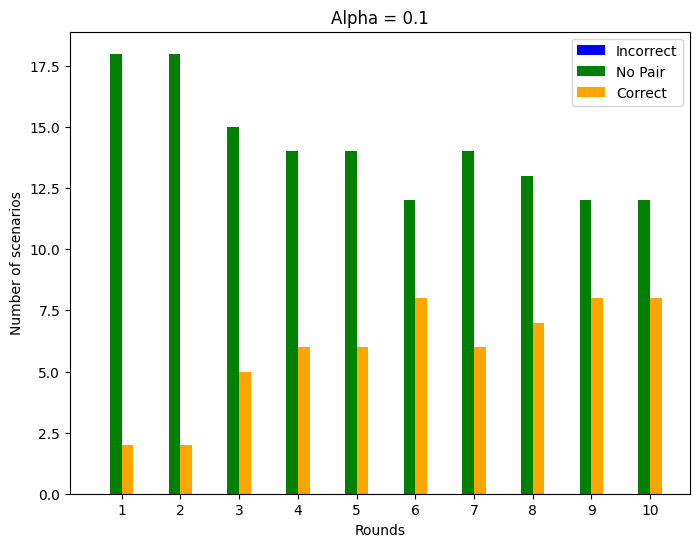

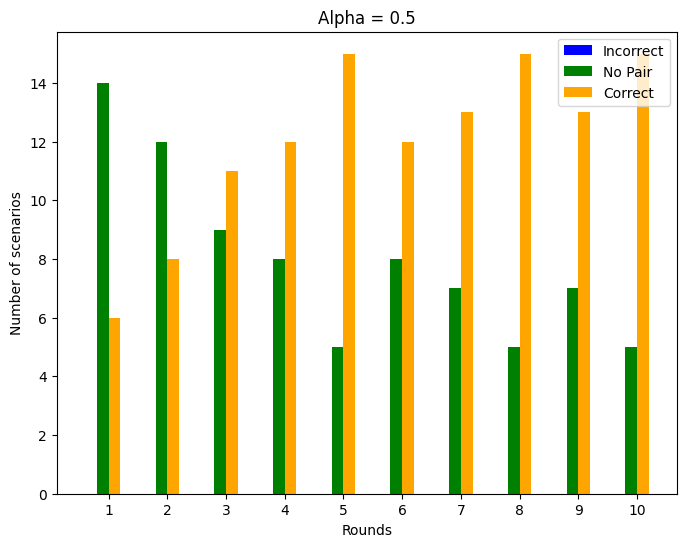

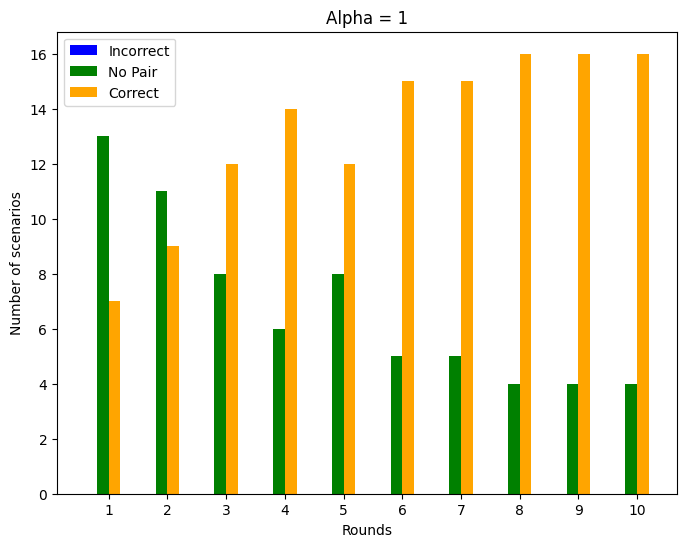

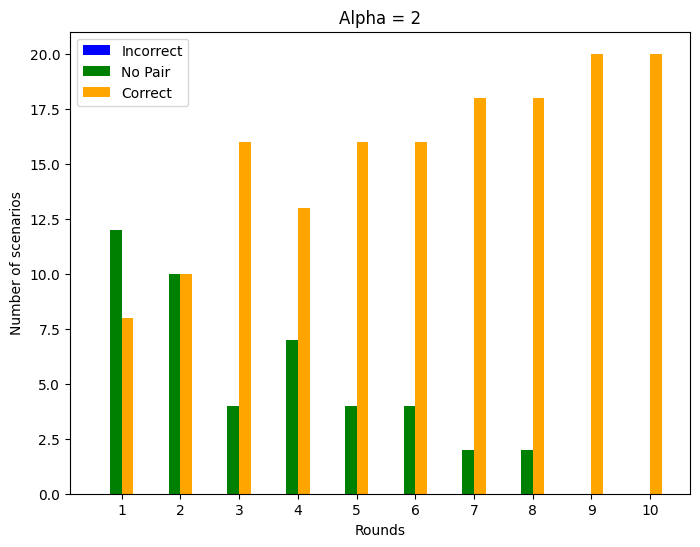

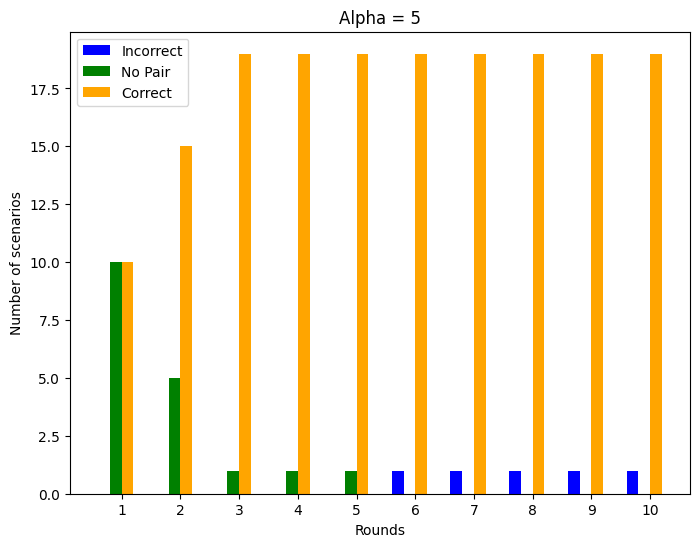

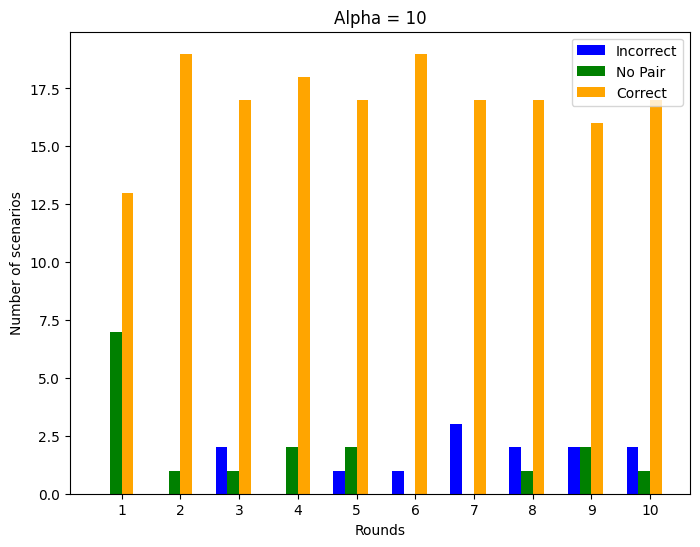

In [ ]:
import numpy as np
import json

# Load the dictionary from the results.json file
with open('results.json', 'r') as file:
    results_dict = json.load(file)

ground_truth = np.array([1, 5, 4, 2, 5, 6, 1, 4, 3, 3])
alphas = [0.1, 0.5, 1, 2, 5, 10]
scenarios = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for alpha in alphas:
    histograms = np.zeros((10, 3))
    for i, scenario in enumerate(scenarios):
        estimations = np.array(results_dict[str(alpha)][str(scenario)]["estimations"])

        correct_guesses = (estimations == ground_truth[i]) * 2
        no_pair_guesses = (estimations == 0) * 1
        classed_guesses = correct_guesses + no_pair_guesses

        for j in range(10):
            histograms[j, classed_guesses[0][j]] += 1
            histograms[j, classed_guesses[1][j]] += 1
    
    # Plotting the grouped bar chart
    fig, ax = plt.subplots(figsize=(8, 6))

    x_positions = np.arange(10)
    bar_width = 0.2

    classes = ['Incorrect', 'No Pair', 'Correct']
    for i, classe in enumerate(classes):
        ax.bar(x_positions + (i * bar_width), histograms[:, i], width=bar_width, label=classe, color=colors[i])

    ax.set_ylabel("Number of scenarios")
    ax.set_xlabel("Rounds")
    ax.set_title(f"Alpha = {alpha}")
    ax.set_xticks(x_positions + (len(classes) * bar_width) / 2)
    ax.set_xticklabels(range(1,11))
    ax.legend()

    plt.show()


# Arthur's Information Retrieval problem

In [ ]:
from main import main
import torch

# Parameters of the Information Retrieval Situation
#TODO: change the parameters according to the task
n_docs = 4 # number of documents taken into account for building the matrix
n_tokens = 5 # number of tokens taken into account for building the matrix
n_tokens_query = 3 # number of tokens corresponding to the query (once the query's tokens have been extended to a more diverse set of tokens thanks to BERT)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model of the game
meanings_A = ["Document_" + str(i) for i in range(n_docs)]
meanings_B = ["Nothing"]
utterances_A = ["Token_" + str(i) for i in range(n_tokens)]
utterances_B = ["Nothing"]
Y = ["Document_" + str(i) for i in range(n_docs)]
game_model = {"mA": meanings_A, "mB": meanings_B, "u": utterances_A, "v": utterances_B, "y": Y}

# Define the prior
prior = torch.zeros((n_docs, 1, n_docs), device=device, dtype=torch.float32)
for i in range(n_docs):
    prior[i, 0, i] = 1

initial_prior = prior * 1/len(meanings_A) * 1/len(meanings_B)
print(initial_prior)

# Define the lexica
#TODO: change lexicon_A according to the task 
# For Arthur's Information Retrieval, we put the matrix we get from spade. The first dimension corresponds to the documents and the second dimension corresponds to the tokens.
lexicon_A = torch.tensor([
    [1, 0, 1, 1, 1], 
    [1, 1, 0, 0, 0], 
    [1, 0, 0, 0, 1],
    [0, 0, 1, 1, 0],
    ], device=device, dtype=torch.float32)

lexicon_B = torch.tensor([
    [1],
    ], device=device, dtype=torch.float32)

initial_lexica = [lexicon_A, lexicon_B]

# Fix the meanings observed by the agents
# A_meaning = random.randint(0, len(meanings_A)-1)
# B_meaning = random.randint(0, len(meanings_B)-1)
A_meaning = None
B_meaning = 0

# Fix the utterances observed by the agents
#TODO: change A_utterances according to the task
# For Arthur's Information Retrieval, we put the tokens corresponding to the query
A_utterances = [0, 4, 4]
B_utterances = [0 for i in range(n_tokens_query)]

# Define the parameters
alpha = 1
number_of_rounds = n_tokens_query
RSA_depth = 1
verbose = False

# Run the Interactive RSA
main(initial_lexica, initial_prior, game_model, A_meaning, B_meaning, A_utterances, B_utterances, alpha, number_of_rounds, RSA_depth, device, verbose)

2024-09-11 10:26:48,021 - INFO - Agent A's meaning is not known.
2024-09-11 10:26:48,023 - INFO - Agent B observes: Nothing / id=0.
2024-09-11 10:26:48,031 - INFO - Estimated meaning by Agent B: Document_2


Using device: cuda
tensor([[[0.2500, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.2500, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.2500, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.2500]]], device='cuda:0')


# Run PIP model

In [1]:
from PIP import InfoJigsaw, PIP

grid_size = (2, 3)
objects = [
    ("square", "blue", (0, 0), "A", 1),
    ("circle", "yellow", (0, 1), "B", 2),
    ("diamond", "green", (0, 2), "C", 3),
    ("square", "yellow", (1, 0), "B", 1),
    ("circle", "blue", (1, 1), "A", 2),
    ("diamond", "green", (1, 2), "C", 1)
]
goal = ("A", 1)

game = InfoJigsaw(grid_size, objects, goal)
pip_agent = PIP(game, max_k=1, alpha=10, lookahead=1, history_length=2)

context = []
agent = 0
state_agents = [("A","B","C","B","A","C"), (1,2,3,1,2,1)]

for _ in range(10):
    action = pip_agent.act(agent, context, state_agents[agent])
    context.append(action)
    if game.is_terminal(context):
        break
    agent = 1 - agent

********************
Agent acting:  0
729


Infering; Agent: 0, Depth: 1, Context: [], k: 1: 100%|██████████| 729/729 [00:00<00:00, 1383550.96it/s]


Choosing an action...
Chosen action:  say_(0, 2)
********************
********************
Agent acting:  1
729


Infering; Agent: 1, Depth: 1, Context: ['say_(0, 2)'], k: 1:  33%|███▎      | 243/729 [01:45<03:30,  2.31it/s]


KeyboardInterrupt: 

In [21]:
next(iter(game.S[0]))

('C', 'A', 'A', 'A', 'A', 'A')